In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import os
from astropy import wcs
from astropy.table import Table, hstack, Column
from astropy.utils.console import ProgressBar
import pandas as pd

In [2]:
### load constants and functions
# Image information and assumptions
distance        = 8340. # distance to GC; Reid et al. 2014
#Temp            = 20.0
Wave            = (3.0e8/226.e9)
Wave0           = 1.3e-3
k0              = 0.899
nu              = 3.e08/Wave
nu0             = 3.e08/Wave0
beta            = 1.75
Kappag2d        = k0*((nu/nu0)**beta)
g2d             = 100.0
Kappa           = Kappag2d / g2d
mu              = 2.8 # express everything in H2

dustTemp = 20

# Constants
G = 6.67408e-11
msun = 1.989e33
mh = 1.6737236e-27
pc2cm = 3.08567758e18
as2persr = 4.25e10 
percm2perm = 1.0e6
JyperSr_to_JyperPix = (3.0462*(10**-4))*((0.00013888888888)**2)
JyperSr_to_Jyperassqr = ((np.pi*180.)**(-2))*(3600**(-1))
hplanck = 6.63e-34
clight = 2.99792e8
kboltzmann = 1.381e-23
sin1yr = 3.15569e7
arcsec2pc = distance/((360./(2.*np.pi))*60.*60.)

def planck_wave( Wave, Temp ):

    # Planck function using wavelength

    planck_conv_wave = 1.e-26 * clight / Wave**2.0

    planck = ((2.0*hplanck*clight**2.0)/(Wave**5.0))*(1.0/(np.exp((hplanck*clight)/(Wave*kboltzmann*Temp))-1.0))
    planck = planck/planck_conv_wave

    return planck

def mass_calc_submm( Wave, Temp, Kappa, Integrated_Flux, Obj_Dist ):

    Obj_Dist = Obj_Dist * pc2cm
    #from planck_func import planck_wave
    B = planck_wave( Wave, Temp )
    Mass = (Obj_Dist**2. * Integrated_Flux) / ( Kappa * B )
    Mass = Mass / msun
    return Mass

def radius_from_mass_const_col_density(Mass_solar,col_dens):
    #print Mass_solar
    Mass = Mass_solar * (msun/1000.0)
    #print Mass
    col_dens = col_dens * (10**4) #convert from cm^-2 to m^-2

    Radius_sqrd = (Mass / (mu * mh * col_dens)) / (np.pi)
    #print Radius_cubed
    Radius_cm = Radius_sqrd**(1./2.)
    #print Radius_cm
    Radius_pc = Radius_cm / (pc2cm/100)
    return Radius_pc
   
    
def mass_from_radius_const_col_density(Radius_pc,col_dens):
    Radius_cm = Radius_pc * (pc2cm)#/100) 
    Radius_sqrd = Radius_cm**2
    Mass = Radius_sqrd * (np.pi) * (mu * mh * col_dens)
    col_dens = col_dens * (10**4) #convert from cm^-2 to m^-2
    Mass_solar = Mass / (msun/1000.0)
    return Mass_solar

In [16]:
### Load tables

targetname = '_rms1e7_dv3_dd1_dp50_pp6_pm2_gal_5-28-19.fits'
target_id = targetname
path = os.path.expanduser('/Users/hph/cmzoom_catalog/catalog_5-28-19/')
catalog = Table.read(path+'master_tab'+targetname)
df = catalog.to_pandas()
tff_spherical = catalog['tff']
mass = catalog['mass']
mass_bgsub = catalog['mass_bgsub']
r_eff_as = catalog['r_eff']
r_eff_pc = r_eff_as * arcsec2pc
flux_integrated = catalog['flux_integrated']
noise_JySr = catalog['noise']
noise_Jyas = noise_JySr / as2persr
noise = noise_Jyas * catalog['area_exact']
flux_integrated = catalog['flux_integrated']
noise_mass = mass_calc_submm(Wave, dustTemp, Kappa, noise, distance)

In [15]:
for i in range(len(obj_id_new)):
    print(catalog['obj_ID'][i]+' -----------------'+ obj_id_new[i])

G359.615-0.243c -----------------G0.001-0.058a
G359.615-0.243a -----------------G0.001-0.059b
G359.615-0.243b -----------------G0.001-0.060c
G0.316-0.201c -----------------G0.001-0.061d
G0.316-0.201e -----------------G0.001-0.062e
G0.316-0.201a -----------------G0.001-0.063f
G0.316-0.201d -----------------G0.001-0.064g
G0.316-0.201b -----------------G0.001-0.065h
G359.648-0.133b -----------------G0.001-0.066i
G359.648-0.133d -----------------G0.001-0.067j
G359.648-0.133a -----------------G0.001-0.068k
G359.648-0.133c -----------------G0.001-0.069l
G1.670-0.130c -----------------G0.001-0.070m
G1.670-0.130b -----------------G0.001-0.071n
G1.670-0.130a -----------------G0.068-0.075a
G1.670-0.130d -----------------G0.068-0.076b
G359.484-0.132c -----------------G0.068-0.077c
G359.484-0.132a -----------------G0.068-0.078d
G359.484-0.132b -----------------G0.068-0.079e
G0.068-0.075a -----------------G0.070-0.035a
G1.683-0.089a -----------------G0.070-0.036b
G359.87-0.082i -----------------G0.

In [65]:
#### load csv from by eye RBG work
rgb_hr = pd.read_csv('/Users/hph/Dropbox/CMZoom_Data/final_catalog/high_reliability/RBG_By_Eye_Columns_hr.csv')

o_ir_8um = np.array(rgb_hr['8μm point'])
o_ir_24um = np.array(rgb_hr['24μm point'])
o_ir_70um = np.array(rgb_hr['70μm point'])
o_an_yso = np.array(rgb_hr['An YSO: +'])
o_immer_yso = np.array(rgb_hr['Immer YSO: X'])
o_yusef_zadeh_yso = np.array(rgb_hr['Yusef-Zadeh YSO: ●'])
o_h20_maser = np.array(rgb_hr['H2O Maser:  •'])
o_ch3oh_maser = np.array(rgb_hr['CH3OH Maser:  ◆'])
o_guttermuth_24um = np.array(rgb_hr['Guttermuth 24μm pt. ●'])
o_molinari_70um = np.array(rgb_hr['Molinari 70μm pt. ◘'])

#### add new columns to catalog
obj_id_new = rgb_hr['Cloud ID']+rgb_hr['Leaf ID']

### temporarily set ? to 1 or 0
o_ir_8um[np.where(o_ir_8um == '?')]=1
o_ir_8um[np.where(o_ir_8um == '1 (foreground?)')]=1
o_ir_24um[np.where(o_ir_24um == '?')]=1
o_ir_70um[np.where(o_ir_70um == '?')]=1
o_an_yso[np.where(o_an_yso == '?')]=1
o_immer_yso[np.where(o_immer_yso == '?')]=1
o_yusef_zadeh_yso[np.where(o_yusef_zadeh_yso == '?')]=1
o_h20_maser[np.where(o_h20_maser == '?')]=1
o_ch3oh_maser[np.where(o_ch3oh_maser == '?')]=1
o_guttermuth_24um[np.where(o_guttermuth_24um == '?')]=1
o_molinari_70um[np.where(o_molinari_70um == '?')]=1

/Users/hph/anaconda/envs/cmzoom3/lib/python3.4/site-packages/ipykernel/__main__.py:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [66]:
o_ir_8um

array(['0', '1', '1', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0',
       '0', '1', '0', '0', '0', '0', 1, '0', '1', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', 1, 1, '0', '0', '0', '0', '0', 1, 1, '0',
       '0', 1, '0', '0', '0', '0', 1, '0', '0', 1, '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', 1, '0', '0', 1, '0', '0', 1, 1, '0', '0',
       1, 1, 1, 1, '0', 1, '0', '0', 1, '1', '1', '1', '0', '0', '1', '0',
       1, '0', 1, '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', 1, '0', '0', '0', '0', '0', '0', '0', '0', '1',
       '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', 1, 1,
       '0', '1', '1', '0', '0', '0', '0', '0', 1, '0', '0', '0', '0', '0',
       '0', 1, '0', '0', '0', '0', '0', '0'], dtype=object)

In [50]:
rgb_hr

,Cloud ID,Leaf ID,8μm point,8μm ext.,24μm point,24μm ext.,70μm point,70μm ext.,An YSO: +,Immer YSO: X,Yusef-Zadeh YSO: ●,H2O Maser: •,CH3OH Maser: ◆,Guttermuth 24μm pt. ●,Molinari 70μm pt. ◘
0,G0.001-0.058,a,0,0,0,0,0,0,0,0,0,0,0,0,0
1,G0.001-0.058,b,1,0,1,0,1,0,0,0,0,0,0,0,1
2,G0.001-0.058,c,1,0,0,0,0,0,0,0,0,0,0,0,0
3,G0.001-0.058,d,0,0,0,0,0,0,0,0,0,0,0,0,0
4,G0.001-0.058,e,0,0,0,0,0,0,0,0,0,0,0,0,0
5,G0.001-0.058,f,0,0,0,0,0,0,0,0,0,0,0,0,0
6,G0.001-0.058,g,1,0,1,0,1,0,0,0,0,0,0,0,1
7,G0.001-0.058,h,0,0,0,0,0,0,0,0,0,0,0,0,0
8,G0.001-0.058,i,0,0,0,0,0,0,0,0,0,0,0,0,0
9,G0.001-0.058,j,1,0,0,0,0,0,0,0,0,0,0,0,0


In [68]:


ir_8um = np.zeros(152)
ir_24um = np.zeros(152)
ir_70um = np.zeros(152)
an_yso = np.zeros(152)
immer_yso = np.zeros(152)
yusef_zadeh_yso = np.zeros(152)
h20_maser = np.zeros(152)
ch3oh_maser = np.zeros(152)
guttermuth_24um = np.zeros(152)
molinari_70um = np.zeros(152)

for i in range(len(catalog['obj_ID'])):
    ind = np.where(catalog['obj_ID'] == obj_id_new[i])
    ir_8um[ind] = o_ir_8um[i]
    ir_24um[ind] = o_ir_24um[i]
    ir_70um[ind] = o_ir_70um[i]
    an_yso[ind] = o_an_yso[i]
    immer_yso[ind] = o_immer_yso[i]
    yusef_zadeh_yso[ind] = o_yusef_zadeh_yso[i]
    h20_maser[ind] = o_h20_maser[i]
    ch3oh_maser[ind] = o_ch3oh_maser[i]
    guttermuth_24um[ind] = o_guttermuth_24um[i]
    molinari_70um[ind] = o_molinari_70um[i]
    
#catalog.add_column(Column(name=k, data=columns[k]))

In [69]:
### actually add the columns: 
catalog.add_column(Column(name='ir_8um', data=ir_8um))
catalog.add_column(Column(name='ir_24um', data=ir_24um))
catalog.add_column(Column(name='ir_70um', data=ir_70um))
catalog.add_column(Column(name='immer_yso', data=immer_yso))
catalog.add_column(Column(name='yusef_zadeh_yso', data=yusef_zadeh_yso))
catalog.add_column(Column(name='h20_maser', data=h20_maser))
catalog.add_column(Column(name='ch3oh_maser', data=ch3oh_maser))
catalog.add_column(Column(name='guttermuth_24um', data=guttermuth_24um))
catalog.add_column(Column(name='molinari_70um', data=molinari_70um))
catalog.add_column(Column(name='an_yso', data=an_yso))

In [75]:
catalog

obj_ID,index,area_ellipse,area_exact,flux_integrated,major_sigma,minor_sigma,position_angle,radius,glon,glat,r_eff,noise,flux_integrated_bgsub,npix,mean_cont_flux,min_flux_integrated,peak_cont_flux,min_cont_flux,ColumnDensity,mass,N,r_eff_pc,Sigma,n,rho,tff,glon_0,mass_bgsub,YSO,water,methanol,H2CO_gas_temp,Total_luminosity,Cool_luminosity,Warm_luminosity,Cool_dust_temp,24micron,70micron,overdensity,ir_8um,ir_24um,ir_70um,immer_yso,yusef_zadeh_yso,h20_maser,ch3oh_maser,guttermuth_24um,molinari_70um,an_yso
str21,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
G359.615-0.243c,15,15.9364296274,44.9999999942,0.0671127701747,3.06661864254,1.193255163,49.9898738763,1.91291885038,-0.376065101089,-0.247105584347,3.78469878279,18914213.5915,0.027139740231,180,63451649.6998,0.0399730299437,138673398.294,37792110.253,6.80581e+22,109.172430599,1.44564211973e+23,0.153028470648,0.241960533295,105062.815063,4.92369116547e-16,94869.1773658,0.376065101089,44.1482507595,0.0,0.0,0.0,58.6884563921,5749.80130153,3224.77101598,2525.03028554,19.8062286377,0.0,0.0,2.12412855887,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G359.615-0.243a,20,50.2792438275,259.249999967,2.09203416104,3.43244965251,3.36346278021,176.637353841,3.39778113644,-0.38536543387,-0.243232236543,9.08415312413,12875155.131,1.74124785156,1037,343320924.429,0.350786309479,1726650427.77,57566583.8524,1.4557e+23,3403.11469282,1.79999813602e+24,0.367303751104,3.01269936021,236839.024052,1.10992857908e-15,63186.3137875,0.38536543387,2832.49014659,0.0,1.0,1.0,94.8146708078,8272.5794838,5656.42186461,2616.15761918,20.9772777557,0.0,1.0,12.3651995439,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
G359.615-0.243b,21,11.7528235605,34.7499999956,0.0751624231646,2.17225448852,1.24232028742,115.393864126,1.64275251347,-0.382067420433,-0.244585891023,3.32584854488,14746766.2084,0.0281378006318,139,92022966.7286,0.0470246225328,170279866.426,57572766.2679,8.59479e+22,122.266811595,1.77513315515e+23,0.134475567446,0.297108225491,173392.855189,8.12592798645e-16,73847.2032473,0.382067420433,45.7717969127,1.0,0.0,0.0,61.0407072495,7480.17341577,4643.48102648,2836.69238929,20.5810909271,0.0,0.0,2.06536057165,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
G0.316-0.201c,67,25.2111402512,71.7499999908,0.097091592185,3.77731448988,1.53253855154,45.0055027208,2.4060091598,0.322318437803,-0.203190757491,4.77898883978,18081927.0485,0.0461595292141,287,57571823.3361,0.0509320629709,121963054.868,30200626.3216,4.64722e+22,157.939019384,1.27144017049e+23,0.193231058894,0.212803941934,75493.8203731,3.53796208676e-16,111916.456115,-0.322318437803,75.0877662551,0.0,0.0,0.0,nan,10910.6504689,3384.5300542,7526.12041475,22.335855484,0.0,0.0,2.73591302748,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G0.316-0.201e,72,4.89979068003,15.499999998,0.0313379274802,1.33721034554,0.841356130839,-173.247644936,1.0606932273,0.314780561824,-0.203441177131,2.2212166115,14706482.5075,0.00900671579952,62,86017900.7448,0.0223312116807,126709999.804,61295300.4205,4.00834e+22,50.9774474223,1.32092611101e+23,0.0898114752438,0.221086520585,242680.769004,1.13730548497e-15,62421.1793999,-0.314780561824,14.6512363145,0.0,0.0,0.0,nan,21713.2436742,5814.33392468,15898.9097495,25.5356731415,0.0,0.0,3.29544380118,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
G0.316-0.201a,75,48.5940825042,208.749999973,1.10990265733,3.72317827245,2.99689563753,109.187423515,3.34035577783,0.315677479464,-0.200720504601,8.15151450544,12936214.1497,0.809303118372,835,226208371.614,0.300599538959,1086655393.55,61264432.3394,5.74303e+22,1805.48009736,1.13281626172e+24,0.329593943884,1.89602131171,173903.292062,8.14984923318e-16,73738.7463124,-0.315677479464,13

In [77]:
#### sum all SF tracers:
sf_ir = catalog['ir_24um']+catalog['ir_70um']+catalog['ir_8um']+catalog['molinari_70um']+catalog['guttermuth_24um']
sf_ir[sf_ir>0]=1
sf_maser = catalog['ch3oh_maser']+catalog['h20_maser']
sf_maser[sf_maser>0]=1
sf_yso = catalog['an_yso']+catalog['immer_yso']+catalog['yusef_zadeh_yso']
sf_yso[sf_yso>0] = 1
sf_maser_yso = sf_maser+sf_yso
sf_maser_yso[sf_maser_yso>0]=1
sf_all = sf_maser_yso+sf_ir
sf_all[sf_all>0]=1


In [92]:
### set up conditionals for excluded indices
overdensity = np.array(catalog['N'],dtype=float) / np.array(catalog['ColumnDensity'],dtype=float)
overdensity[np.isnan(overdensity)]=0

none_cond = sf_all==0
maser_cond = sf_maser>0
yso_cond = sf_yso>0
ir_cond = sf_ir > 0
all_cond = sf_all >0

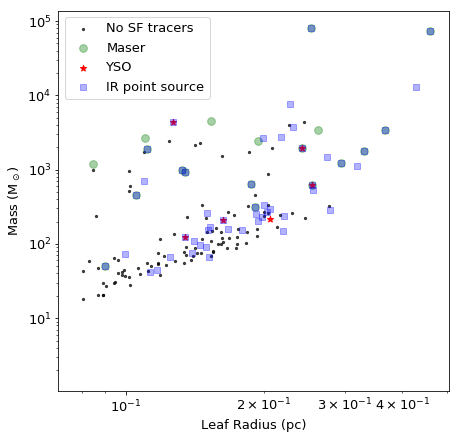

In [89]:
### Playing around with other scatter plots 
plt.rcParams.update({'font.size': 13}) #set fontsize
histfig = plt.figure(3,figsize=(7,7))
histfig.clf()
ax = histfig.gca()
plt.xlabel('Leaf Radius (pc)')# (N$_{SMA}$/N$_{Herschel}$)')
plt.ylabel('Mass (M$_\odot$)')

# quantity1 = catalog['r_eff']
# quantity2 = overdensity
quantity2 = mass
quantity1 = catalog['r_eff']*arcsec2pc

ax.scatter(quantity1[none_cond], quantity2[none_cond],s=20, 
           color='black',marker='.',alpha=.7,label='No SF tracers')
ax.scatter(quantity1[maser_cond], quantity2[maser_cond],s=60, 
           color='forestgreen',marker='o',alpha=.4,label='Maser')
ax.scatter(quantity1[yso_cond], quantity2[yso_cond],s=40, 
           color='red',marker='*',alpha=1.,label='YSO')
ax.scatter(quantity1[ir_cond], quantity2[ir_cond],s=30, 
           color='blue',marker='s',alpha=.3,label='IR point source')


ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_ylim(0.05,40)

#plt.xticks([0.1,0.2,0.3,0.4],[0.1,0.2,0.3,0.4])
#plt.yticks([0.1,1,10],[0.1,1,10])

#ax.grid()

ax.legend()
plt.show()

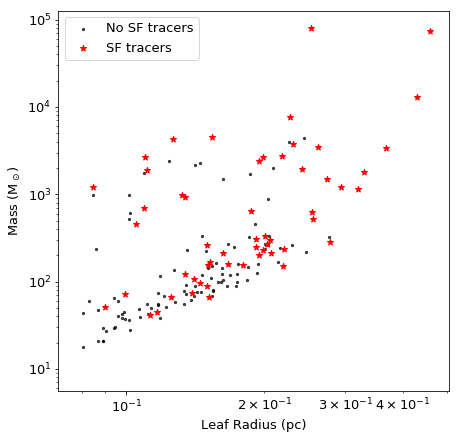

In [93]:
### Playing around with other scatter plots 
plt.rcParams.update({'font.size': 13}) #set fontsize
histfig = plt.figure(3,figsize=(7,7))
histfig.clf()
ax = histfig.gca()
plt.xlabel('Leaf Radius (pc)')# (N$_{SMA}$/N$_{Herschel}$)')
plt.ylabel('Mass (M$_\odot$)')

# quantity1 = catalog['r_eff']
# quantity2 = overdensity
quantity2 = mass
quantity1 = catalog['r_eff']*arcsec2pc

ax.scatter(quantity1[none_cond], quantity2[none_cond],s=20, 
           color='black',marker='.',alpha=.7,label='No SF tracers')
ax.scatter(quantity1[all_cond], quantity2[all_cond],s=40, 
           color='red',marker='*',alpha=1.,label='SF tracers')



ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_ylim(0.05,40)

#plt.xticks([0.1,0.2,0.3,0.4],[0.1,0.2,0.3,0.4])
#plt.yticks([0.1,1,10],[0.1,1,10])

#ax.grid()

ax.legend()
plt.show()

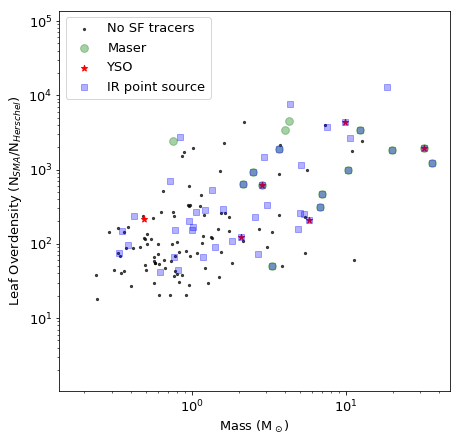

In [108]:
### Playing around with other scatter plots 
plt.rcParams.update({'font.size': 13}) #set fontsize
histfig = plt.figure(3,figsize=(7,7))
histfig.clf()
ax = histfig.gca()
plt.ylabel('Leaf Overdensity (N$_{SMA}$/N$_{Herschel}$)')
plt.xlabel('Mass (M$_\odot$)')

# quantity1 = catalog['r_eff']
# quantity2 = overdensity
quantity2 = mass
quantity1 = overdensity

ax.scatter(quantity1[none_cond], quantity2[none_cond],s=20, 
           color='black',marker='.',alpha=.7,label='No SF tracers')
ax.scatter(quantity1[maser_cond], quantity2[maser_cond],s=60, 
           color='forestgreen',marker='o',alpha=.4,label='Maser')
ax.scatter(quantity1[yso_cond], quantity2[yso_cond],s=40, 
           color='red',marker='*',alpha=1.,label='YSO')
ax.scatter(quantity1[ir_cond], quantity2[ir_cond],s=30, 
           color='blue',marker='s',alpha=.3,label='IR point source')


ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_ylim(0.05,40)

#plt.xticks([0.1,0.2,0.3,0.4],[0.1,0.2,0.3,0.4])
#plt.yticks([0.1,1,10],[0.1,1,10])

#ax.grid()

ax.legend()
plt.show()

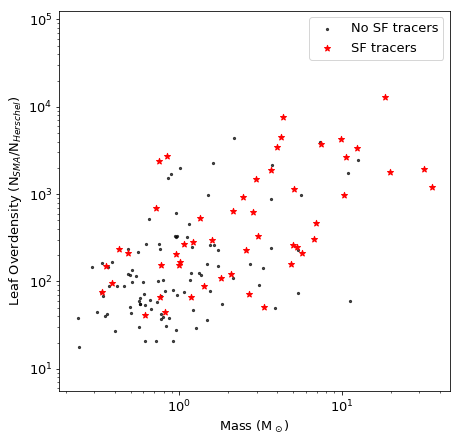

In [109]:
### Playing around with other scatter plots 
plt.rcParams.update({'font.size': 13}) #set fontsize
histfig = plt.figure(3,figsize=(7,7))
histfig.clf()
ax = histfig.gca()
plt.ylabel('Leaf Overdensity (N$_{SMA}$/N$_{Herschel}$)')
plt.xlabel('Mass (M$_\odot$)')

# quantity1 = catalog['r_eff']
# quantity2 = overdensity
quantity2 = mass
quantity1 = overdensity

ax.scatter(quantity1[none_cond], quantity2[none_cond],s=20, 
           color='black',marker='.',alpha=.7,label='No SF tracers')
ax.scatter(quantity1[all_cond], quantity2[all_cond],s=40, 
           color='red',marker='*',alpha=1.,label='SF tracers')



ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_ylim(0.05,40)

#plt.xticks([0.1,0.2,0.3,0.4],[0.1,0.2,0.3,0.4])
#plt.yticks([0.1,1,10],[0.1,1,10])

#ax.grid()

ax.legend()
plt.show()

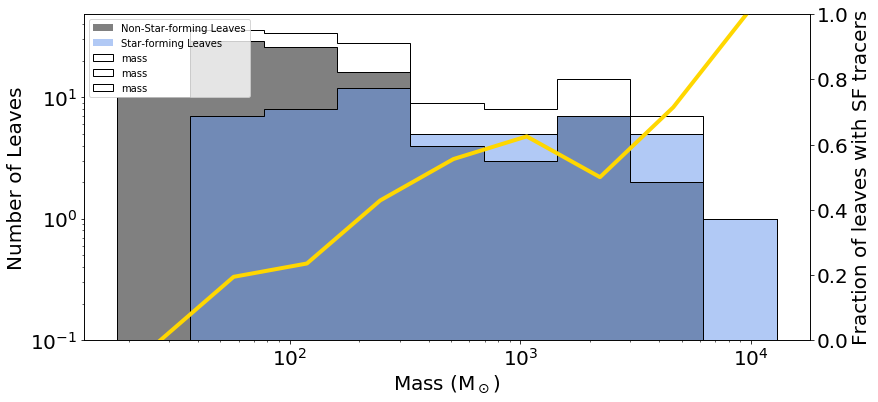

In [111]:
### make overdensity histogram with SF tracers
plt.close()
#print overdensity
#print np.array(catalog['N'])
#print np.array(catalog['ColumnDensity'])
exclude_inds = np.where(overdensity != 0)
od_ex = overdensity[exclude_inds]

#all_tracers_2 = all_maser_2 + all_iryso_2 + all_HII_2
all_tracers_refined = sf_all[exclude_inds]

sf_cond_ex = (all_tracers_refined > 0)
nsf_cond_ex = (all_tracers_refined == 0)

#print len(np.array(overdensity)[nsf_cond_2])

plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16}) #set fontsize


### QUANTITY TO HISTOGRAM:
#OD_area = overdensity * catalog['area_exact'][exclude_inds]
OD_radius = od_ex * catalog['r_eff_pc'][exclude_inds]
hist_quantity = mass[exclude_inds]#catalog['mass'][exclude_inds]#overdensity#OD_radius
###

# Plot Histogram
plt.rcParams.update({'font.size': 20}) #set fontsize
histfig = plt.figure(3,figsize=(13,6))
histfig.clf()
ax = histfig.gca()
plt.ylabel('Number of Leaves')
#plt.xlabel('Column Overdensity (N$_{SMA}$/N$_{Herschel}$) times leaf radius')
#plt.xlabel('Column Overdensity (N$_{SMA}$/N$_{Herschel}$)')
plt.xlabel('Mass (M$_\odot$)')

#plt.legend(loc='upper left', shadow=False, fontsize=18)
#print overdensity
linbins = np.linspace(min(hist_quantity), max(hist_quantity),30)
logbins = np.logspace(np.log10(min(hist_quantity)), np.log10(max(hist_quantity)),10)
#print logbins
#print linbins
### histogram non sources
ax.set_xscale('log')

h2,l2,p2 = ax.hist(hist_quantity[nsf_cond_ex],bins=logbins, color='grey',alpha=1, log=True,label='Non-Star-forming Leaves')
h3,l3,p3 = ax.hist(hist_quantity[sf_cond_ex],bins=logbins, color='cornflowerblue',alpha=0.5, log=True,label='Star-forming Leaves')
h1,l1,p1 = ax.hist(hist_quantity,bins=logbins, color='k',alpha=1, log=True,histtype='step')
h2,l2,p2 = ax.hist(hist_quantity[nsf_cond_ex],bins=logbins, color='k',alpha=1., log=True,histtype='step')
h3,l3,p3 = ax.hist(hist_quantity[sf_cond_ex],bins=logbins, color='k',alpha=1., log=True,histtype='step')
ax2 = ax.twinx()
midpts = (l1[:-1] + l1[1:])/2.
line_frac = ax2.plot(midpts, h3/h1, linestyle='-', color='gold', linewidth=4.0, zorder=-21,label='Fraction of source pixels with SF tracers')
ax2.set_ylabel("Fraction of leaves with SF tracers")
ax2.set_ylim(0,1)
#fill = ax2.fill_between(midpts,h4/h2, color='red',alpha=0.3)
ax2.set_label('Fraction of leaves with SF tracers')
plt.rcParams.update({'font.size': 10})
ax.legend(loc='upper left')
plt.show()